<a href="https://colab.research.google.com/github/MicheleGiambelli/PlotTwisters-Project/blob/main/Progetto%20Data%20aggiornato.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
# Importazione delle librerie necessarie
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import plotly.express as px
import networkx as nx
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# Se stai usando Google Colab, usa questo codice per caricare i file
from google.colab import files

# Carica i file
uploaded = files.upload()

# Mostra i nomi dei file caricati
for filename in uploaded.keys():
    print(f'File {filename} caricato con successo!')

# Leggi i dati (assumendo che 'file5.txt' sia il primo file)
df = pd.read_csv('file5.txt', header=None, delimiter='\t', names=['token', 'ner_tag'])

# Informazioni sul DataFrame
print(df.info())
print(df.head())


Saving file5.txt to file5 (2).txt
File file5 (2).txt caricato con successo!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32520 entries, 0 to 32519
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   token    32520 non-null  object
 1   ner_tag  32520 non-null  object
dtypes: object(2)
memory usage: 508.2+ KB
None
        token ner_tag
0    Millions       O
1          of       O
2  family-run       O
3      #farms       O
4        hold       O


In [ ]:
# Controllo dei valori nulli
print("Valori nulli per colonna:")
print(df.isnull().sum())

# Controllo delle stringhe vuote
blanks = df[df['token'].str.strip() == '']
print(f"Numero di stringhe vuote: {len(blanks)}")


Valori nulli per colonna:
token      0
ner_tag    0
dtype: int64
Numero di stringhe vuote: 0


Mappatura dei tag NER a categorie semplificate

In [32]:
# Mappatura dei tag NER a categorie semplificate
mapping = {
    'B-LOC': 'LOC',
    'I-LOC': 'LOC',
    'B-PER': 'PER',
    'I-PER': 'PER',
    'B-ORG': 'ORG',
    'I-ORG': 'ORG',
    'B-MISC': 'MISC',
    'I-MISC': 'MISC',
    'O': 'O'
}

# Creazione della nuova colonna 'Label'
df['Label'] = df['ner_tag'].map(mapping)

# Visualizzazione delle prime righe
print(df.head(10))


        token ner_tag Label
0    Millions       O     O
1          of       O     O
2  family-run       O     O
3      #farms       O     O
4        hold       O     O
5         the       O     O
6         key       O     O
7          to       O     O
8      global       O     O
9     #hunger       O     O


Creazione dei dizionari per le etichette

In [33]:
# Creazione dei dizionari per le etichette
unique_tags = sorted(df['ner_tag'].unique())
labels_to_indices = {label: idx for idx, label in enumerate(unique_tags)}
indices_to_labels = {idx: label for idx, label in enumerate(unique_tags)}

print("Labels to Indices:", labels_to_indices)
print("Indices to Labels:", indices_to_labels)


Labels to Indices: {'B-LOC': 0, 'B-ORG': 1, 'B-PER': 2, 'I-LOC': 3, 'I-ORG': 4, 'I-PER': 5, 'O': 6}
Indices to Labels: {0: 'B-LOC', 1: 'B-ORG', 2: 'B-PER', 3: 'I-LOC', 4: 'I-ORG', 5: 'I-PER', 6: 'O'}


Raggruppamento dei tokens in frasi

In [34]:
# Definizione della funzione per identificare la fine di una frase
def is_sentence_end(token):
    return token in ['.', '!', '?']

# Inizializzazione del numero di frase
df['Sentence_Num'] = 1
sentence_num = 1

# Assegnazione dei numeri di frase
for i in range(1, len(df)):
    prev_token = df.loc[i - 1, 'token']
    if is_sentence_end(prev_token):
        sentence_num += 1
    df.loc[i, 'Sentence_Num'] = sentence_num

# Visualizzazione delle prime righe per verifica
print(df.head(20))





                     token ner_tag Label  Sentence_Num
0                 Millions       O     O             1
1                       of       O     O             1
2               family-run       O     O             1
3                   #farms       O     O             1
4                     hold       O     O             1
5                      the       O     O             1
6                      key       O     O             1
7                       to       O     O             1
8                   global       O     O             1
9                  #hunger       O     O             1
10                 reveals       O     O             1
11                     #UN   B-ORG   ORG             1
12                  report       O     O             1
13                       .       O     O             1
14  http://t.co/9JKaxcMKJ0       O     O             2
15                  Cousin       O     O             2
16                      of       O     O             2
17        

Filtrare tokens non significativi

In [35]:
# Definizione dei token da rimuovere
punctuation_marks = {'.', ',', ';', ':', '?', '!'}
tokens_to_remove = ['-DOCSTART-']

# Filtraggio dei dati
df_filtered = df[~df['token'].isin(punctuation_marks.union(tokens_to_remove))].copy()

# Visualizzazione delle prime righe del dataframe filtrato
print(df_filtered.head(15))


                     token ner_tag Label  Sentence_Num
0                 Millions       O     O             1
1                       of       O     O             1
2               family-run       O     O             1
3                   #farms       O     O             1
4                     hold       O     O             1
5                      the       O     O             1
6                      key       O     O             1
7                       to       O     O             1
8                   global       O     O             1
9                  #hunger       O     O             1
10                 reveals       O     O             1
11                     #UN   B-ORG   ORG             1
12                  report       O     O             1
14  http://t.co/9JKaxcMKJ0       O     O             2
15                  Cousin       O     O             2


# **Analisi estrapolativa dei dati**

1. **distribuzione dei tag NER**



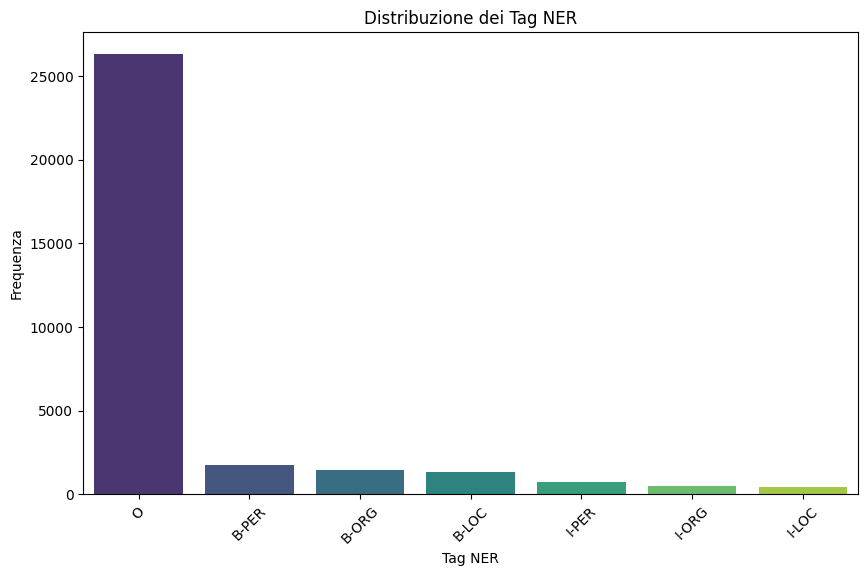

In [37]:
# Conteggio dei tag NER
ner_counts = df['ner_tag'].value_counts()

# Grafico a barre della distribuzione dei tag NER
plt.figure(figsize=(10, 6))
sns.barplot(x=ner_counts.index, y=ner_counts.values, palette='viridis')
plt.title('Distribuzione dei Tag NER')
plt.xlabel('Tag NER')
plt.ylabel('Frequenza')
plt.xticks(rotation=45)
plt.show()


2. **Entità èiù  frequenti per categoria**

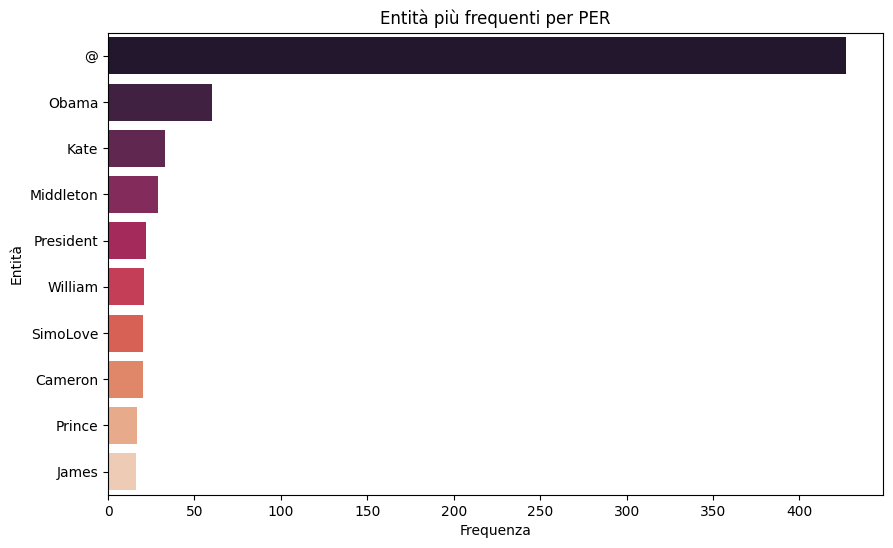

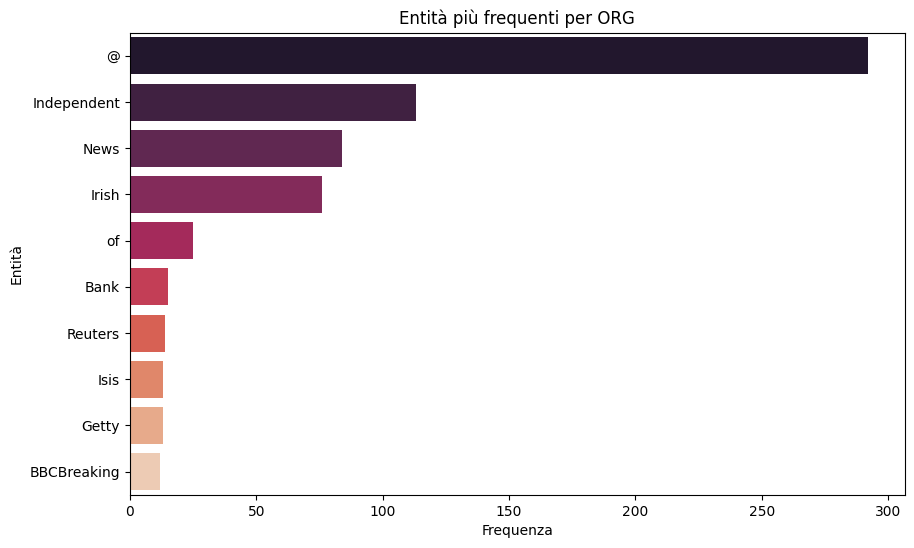

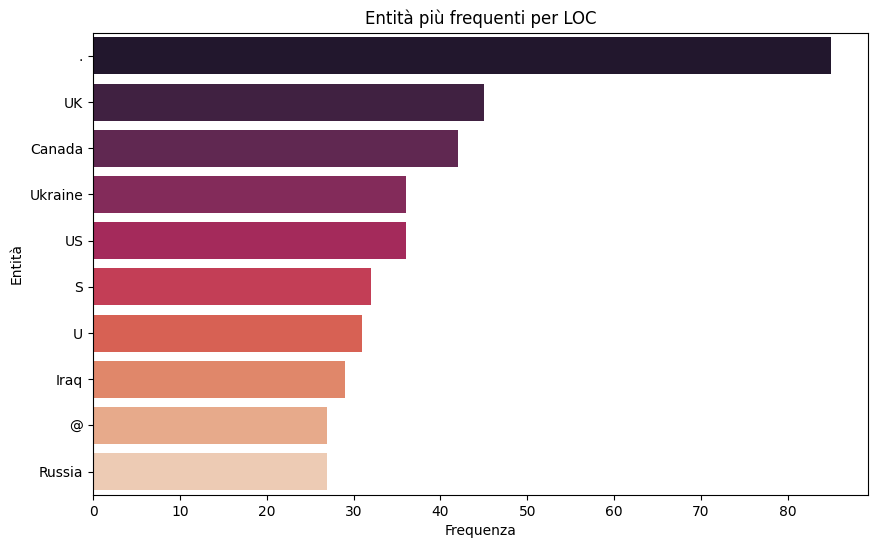

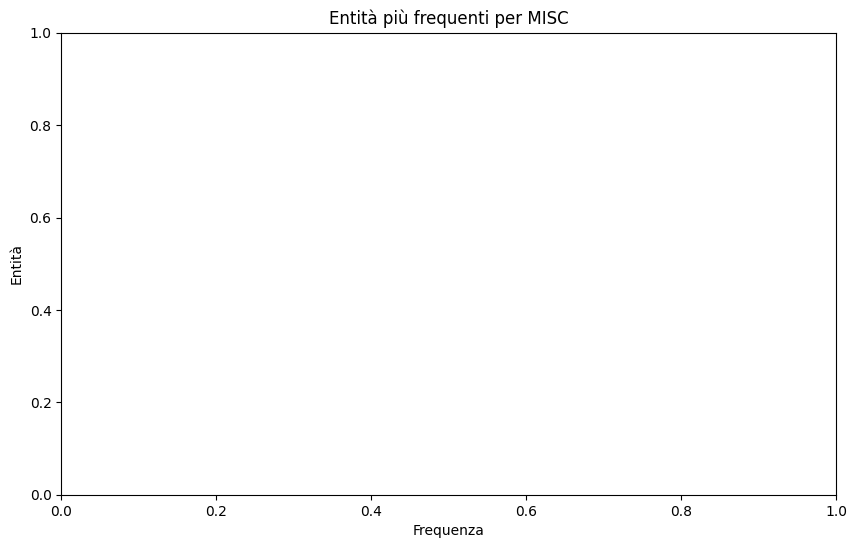

In [38]:
# Lista delle etichette di interesse
labels_of_interest = ['PER', 'ORG', 'LOC', 'MISC']

for label in labels_of_interest:
    top_entities = df[df['Label'] == label]['token'].value_counts().head(10)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_entities.values, y=top_entities.index, palette='rocket')
    plt.title(f'Entità più frequenti per {label}')
    plt.xlabel('Frequenza')
    plt.ylabel('Entità')
    plt.show()


3. Distribuzione lunghezza frasi

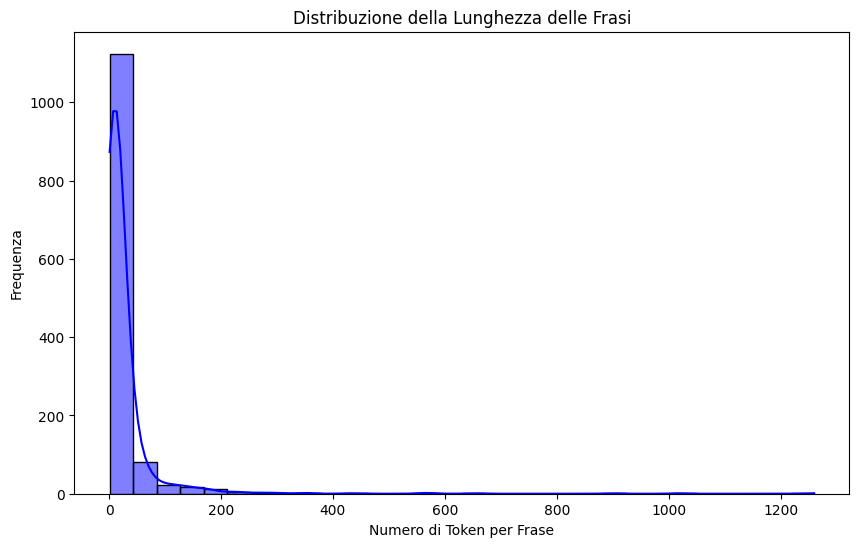

In [39]:
# Calcolo della lunghezza delle frasi in termini di numero di token
sentence_lengths = df.groupby('Sentence_Num')['token'].count()

# Istogramma della distribuzione delle lunghezze delle frasi
plt.figure(figsize=(10, 6))
sns.histplot(sentence_lengths, bins=30, kde=True, color='blue')
plt.title('Distribuzione della Lunghezza delle Frasi')
plt.xlabel('Numero di Token per Frase')
plt.ylabel('Frequenza')
plt.show()


4. **Word Cloud delle parole più frequenti**

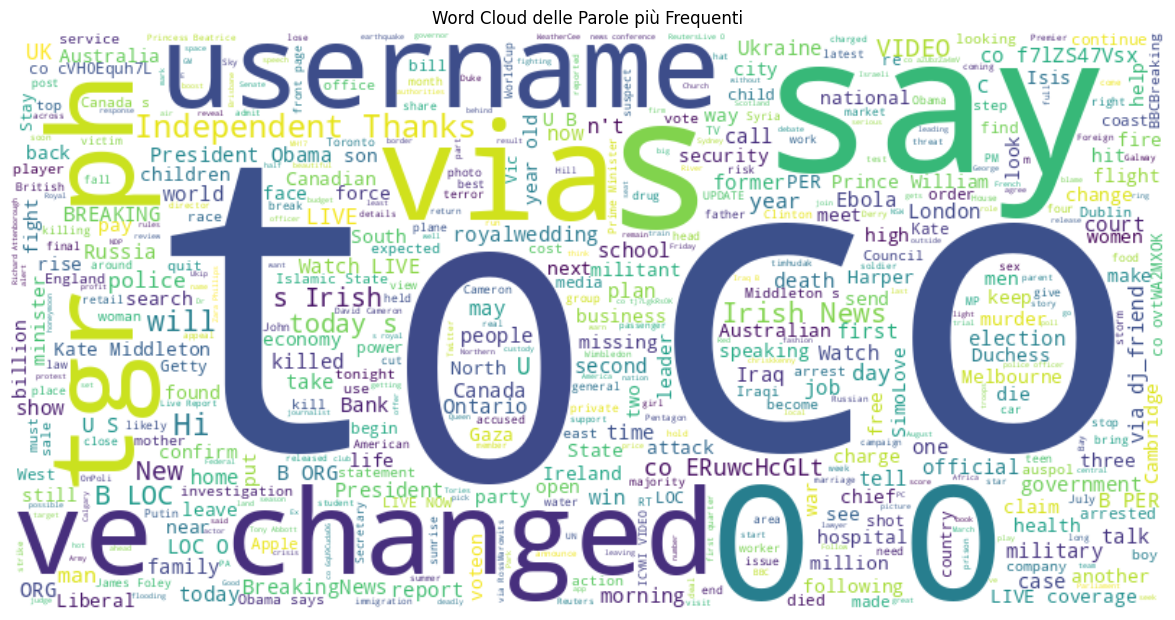

In [40]:
# Creazione del testo completo
text = " ".join(token for token in df_filtered['token'])

# Aggiunta di stopwords personalizzate
stopwords = set(STOPWORDS)
stopwords.update(['DOCSTART', 'http', 'https'])

# Generazione della Word Cloud
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=500, width=800, height=400).generate(text)

# Visualizzazione della Word Cloud
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud delle Parole più Frequenti')
plt.show()


5. **Analisi delle co-occorrenze delle entit**

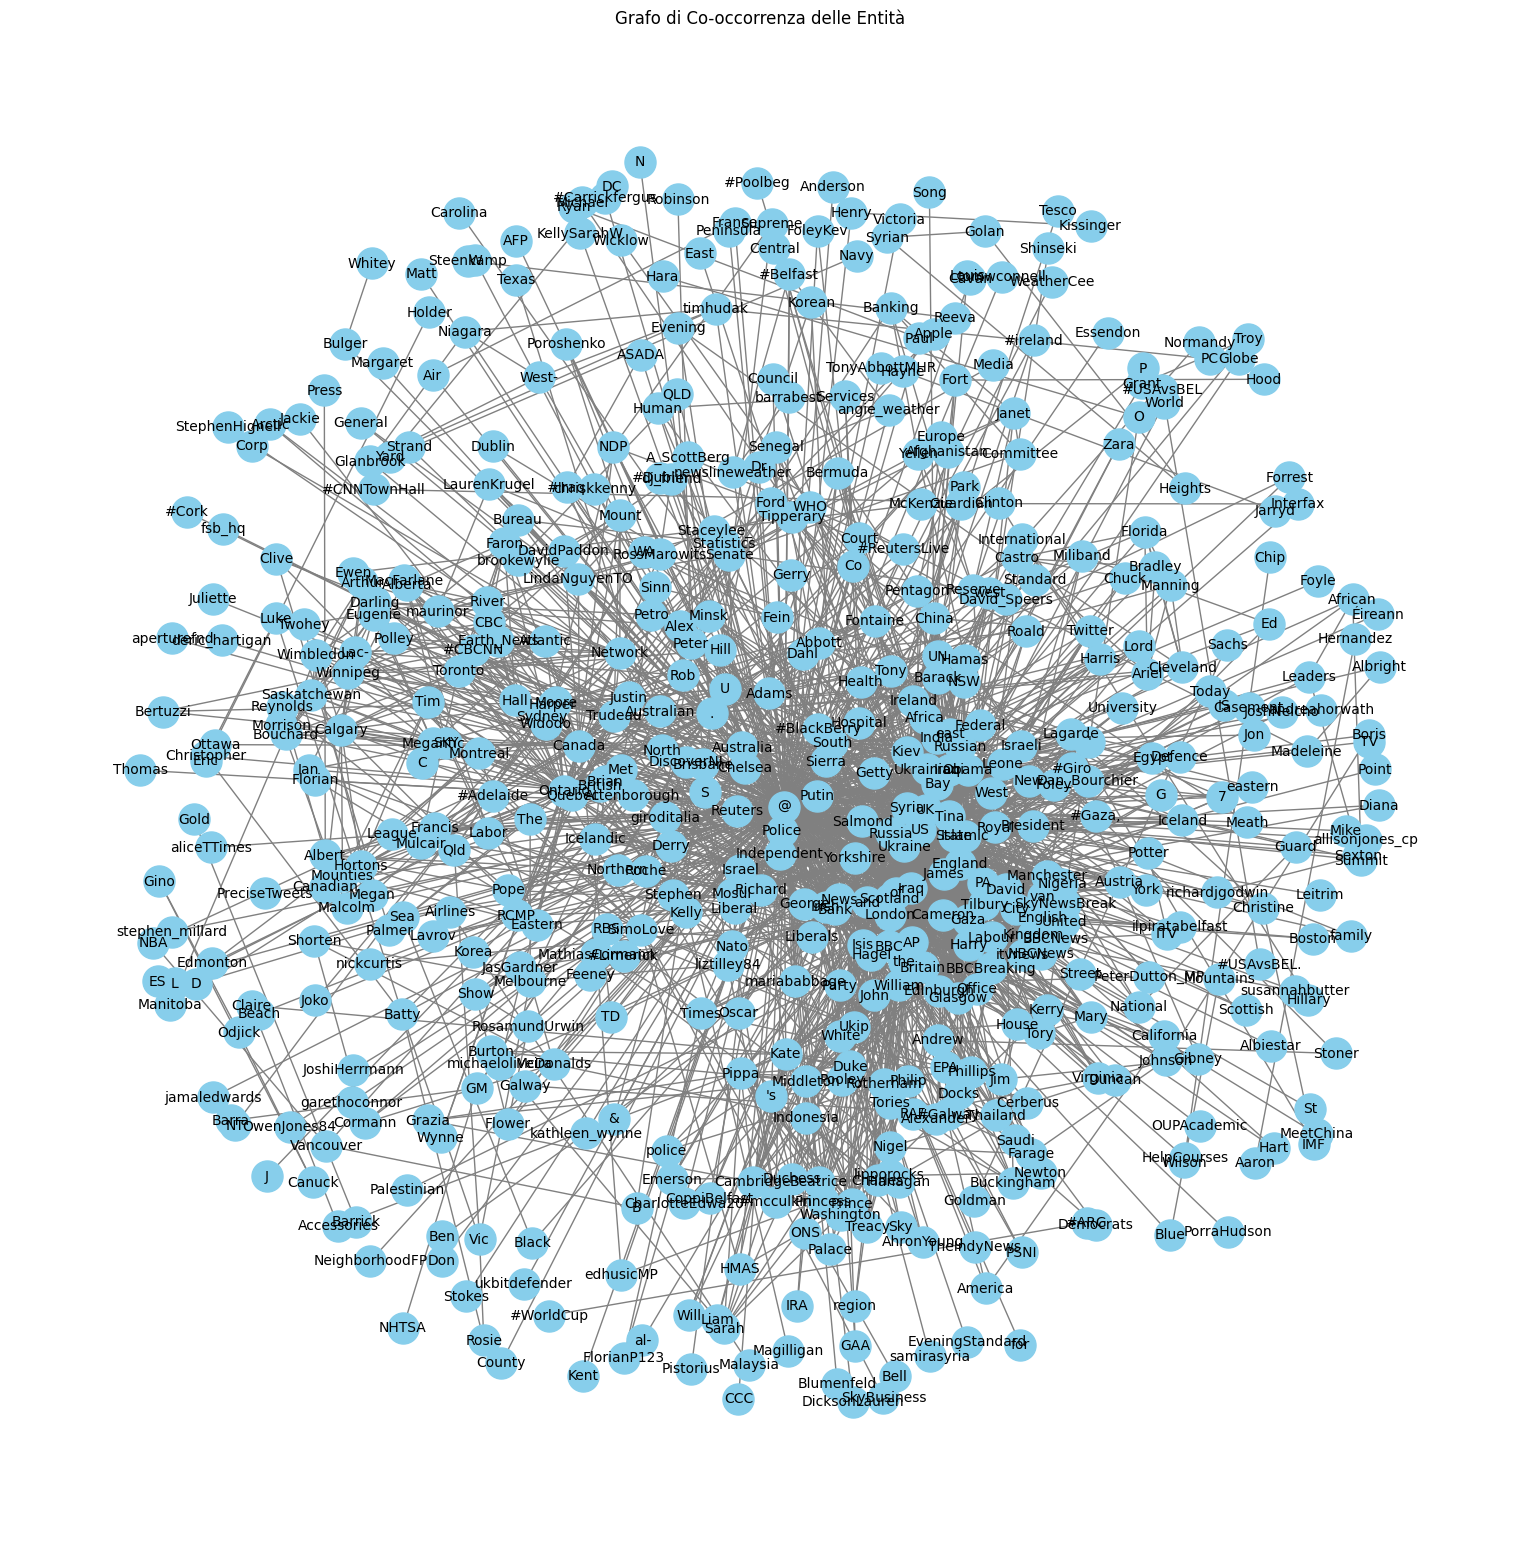

In [41]:
# Estrazione delle entità per frase
entity_sentences = df[df['Label'] != 'O'].groupby('Sentence_Num')['token'].apply(list)

# Creazione delle coppie di entità
co_occurrence = Counter()
for entities in entity_sentences:
    unique_entities = list(set(entities))
    for pair in combinations(unique_entities, 2):
        co_occurrence[pair] += 1

# Creazione del grafo di co-occorrenza
G = nx.Graph()
for (entity1, entity2), weight in co_occurrence.items():
    G.add_edge(entity1, entity2, weight=weight)

# Seleziona le entità con peso maggiore per visualizzazione
edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
weights = [w for w in weights if w > 1]  # Filtra per pesi maggiori di 1

# Riduci il grafo per visualizzazione (opzionale)
small_G = nx.Graph()
for (entity1, entity2), weight in co_occurrence.items():
    if weight > 1:
        small_G.add_edge(entity1, entity2, weight=weight)

# Visualizzazione del grafo
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(small_G, k=0.5)
nx.draw(small_G, pos, with_labels=True, node_size=500, node_color='skyblue', edge_color='grey', linewidths=1, font_size=10)
plt.title('Grafo di Co-occorrenza delle Entità')
plt.show()


6. **Box Plot della lunghezza delle parole per etichetta NER**

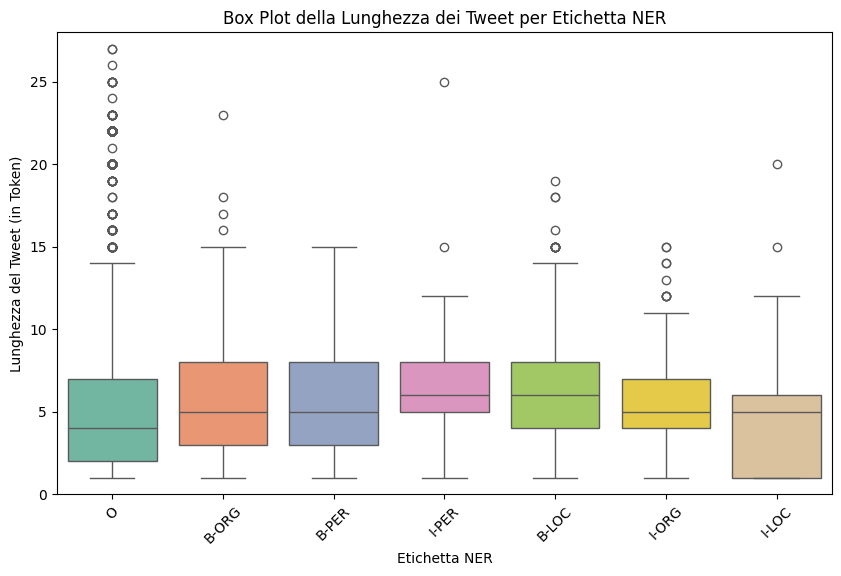

In [ ]:
# Calcola la lunghezza dei token
df['tweet_length'] = df['token'].apply(len)

# Crea il box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='ner_tag', y='tweet_length', palette='Set2')
plt.title("Box Plot della Lunghezza dei Tweet per Etichetta NER")
plt.xlabel("Etichetta NER")
plt.ylabel("Lunghezza del Tweet (in Token)")

# Imposta i limiti dell'asse y
plt.ylim(0, 28)

plt.xticks(rotation=45)
plt.show()



Altra opzione di word cloud

Saving plottwisters_mask.png.png to plottwisters_mask.png (2).png


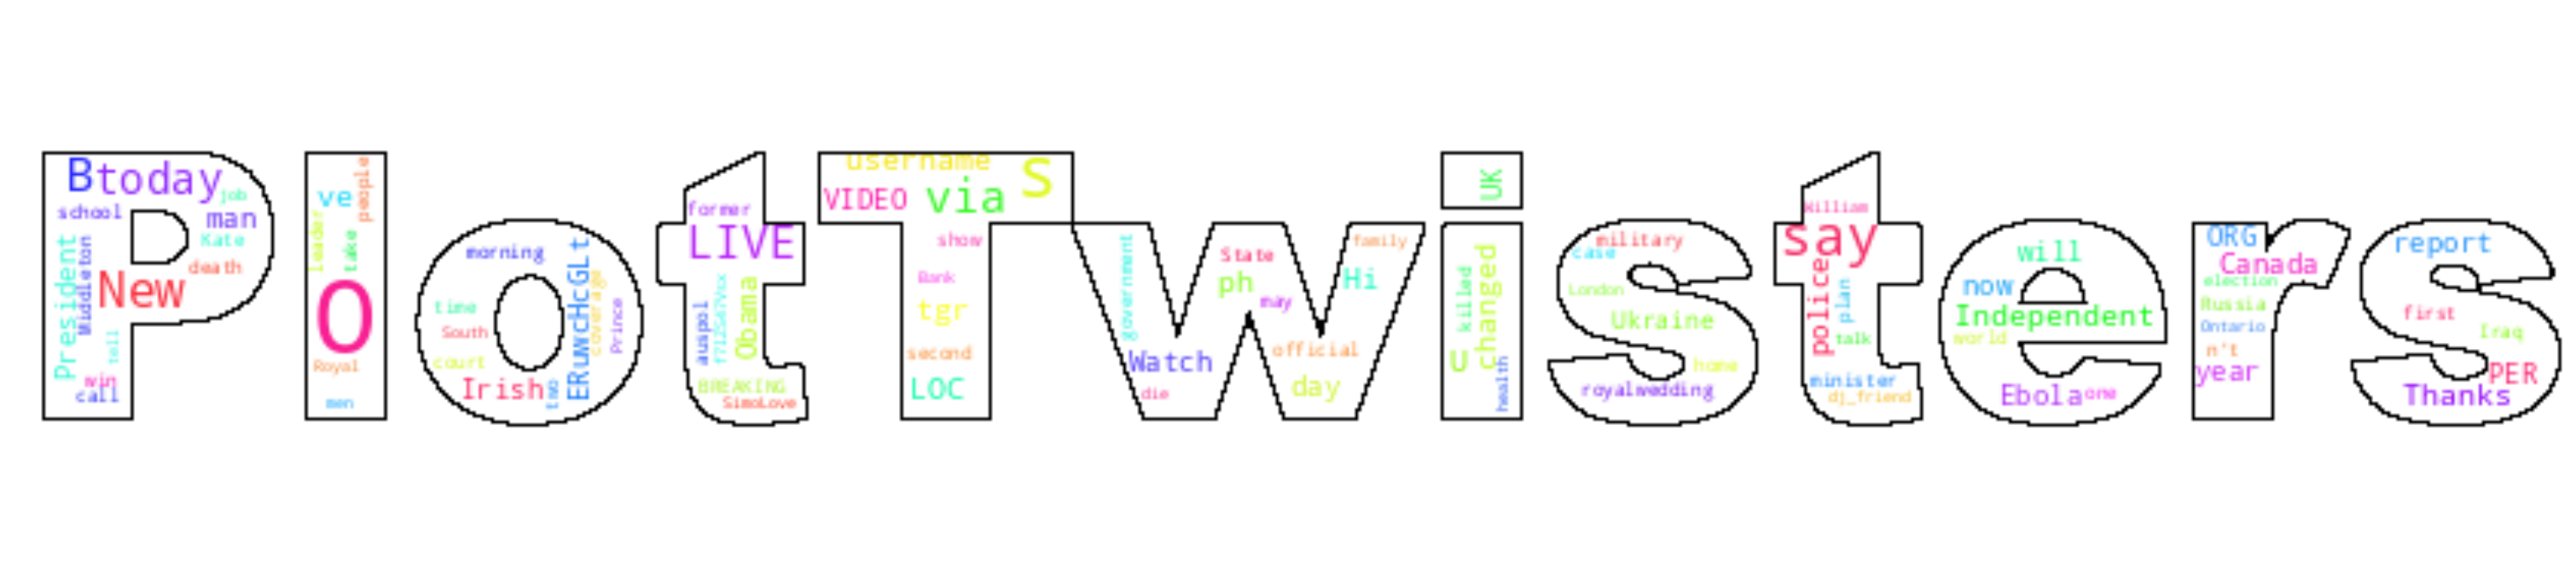

In [43]:
# Importazione delle librerie necessarie
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from google.colab import files
import random
import matplotlib.cm as cm

# Assicurati di avere il DataFrame 'df_filtered' già creato

# Carica l'immagine della maschera
uploaded = files.upload()
mask_image_path = next(iter(uploaded))
mask_image = np.array(Image.open(mask_image_path))

# Prepara il testo
text = " ".join(df_filtered['token'].astype(str))

# Definisci le stopwords
stopwords = set(STOPWORDS)
stopwords.update(['DOCSTART', 'http', 'https', 't', 'co', 'RT'])  # Aggiungi altre parole se necessario

# Funzione di colore personalizzata per parole più vivaci
def random_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    h = int(360.0 * random.random())  # Colori casuali
    s = 90 + random.random() * 10  # Saturazione alta
    l = 50 + random.random() * 10  # Luminosità media
    return f"hsl({h}, {s}%, {l}%)"

# Crea e genera la Word Cloud con colori più vivaci
wordcloud = WordCloud(
    width=mask_image.shape[1],
    height=mask_image.shape[0],
    background_color='white',
    mask=mask_image,
    stopwords=stopwords,
    max_words=1000,
    contour_width=1,
    contour_color='black',
    random_state=42,
    collocations=False  # Evita duplicati di parole
).generate(text)

# Visualizza la Word Cloud con la funzione di colore personalizzata
plt.figure(figsize=(30, 15))  # Aumenta le dimensioni della figura
plt.imshow(wordcloud.recolor(color_func=random_color_func), interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# Salva l'immagine in un file (opzionale)
wordcloud.to_file('plottwisters_wordcloud.png')


**Matrice di Correlazione delle Etichette NER**

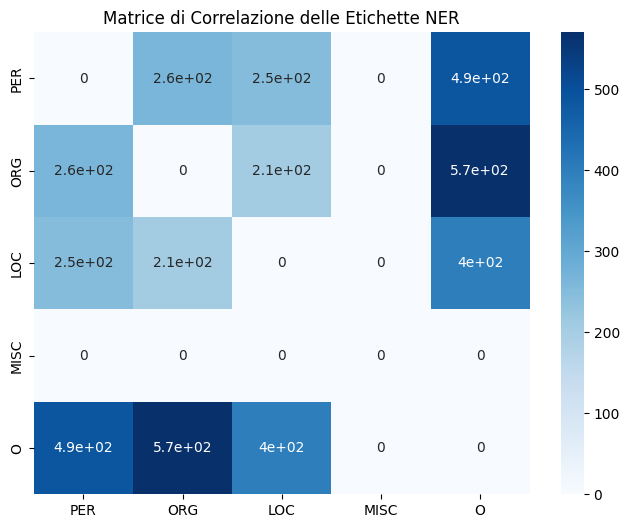

In [44]:
# Creazione di una tabella che indica la presenza di ciascuna etichetta in ogni frase
label_presence = df.groupby('Sentence_Num')['Label'].apply(lambda labels: set(labels))

# Creazione di una matrice di correlazione
from itertools import combinations
labels = ['PER', 'ORG', 'LOC', 'MISC', 'O']
label_matrix = pd.DataFrame(0, index=labels, columns=labels)

for label_set in label_presence:
    for label1, label2 in combinations(label_set, 2):
        if label1 in labels and label2 in labels:
            label_matrix.loc[label1, label2] += 1
            label_matrix.loc[label2, label1] += 1

# Visualizzazione della matrice di correlazione come heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(label_matrix, annot=True, cmap='Blues')
plt.title('Matrice di Correlazione delle Etichette NER')
plt.show()


**Distribuzione delle Parti del Discorso (POS Tags)**

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 59.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


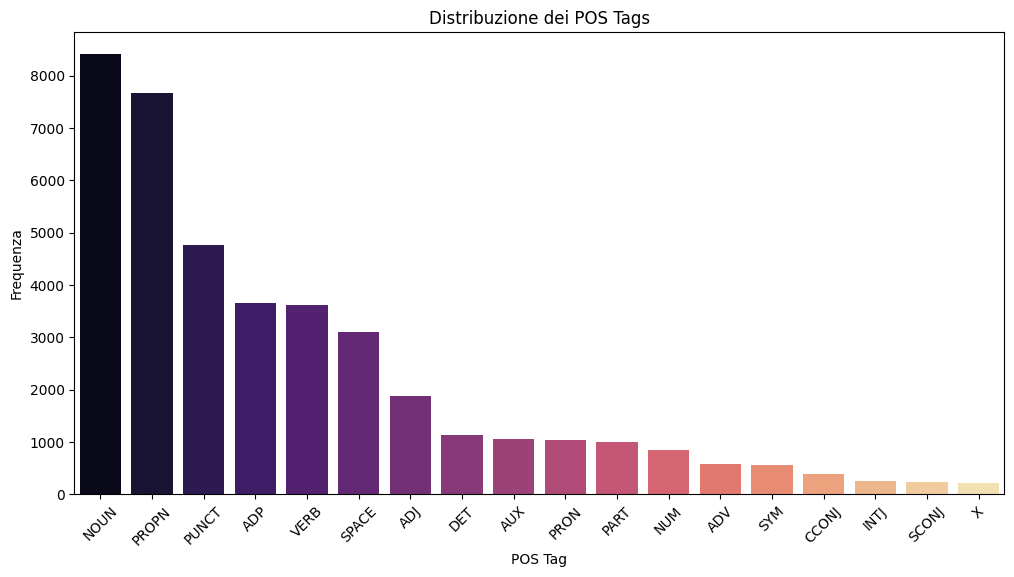

In [45]:
# Installazione di spaCy se non è già installato
!pip install spacy
!python -m spacy download en_core_web_sm

import spacy
nlp = spacy.load('en_core_web_sm')

# Applicazione del POS tagging
texts = df.groupby('Sentence_Num')['token'].apply(lambda tokens: ' '.join(tokens))
docs = list(nlp.pipe(texts))

# Estrarre i POS tags
pos_tags = []
for doc in docs:
    pos_tags.extend([token.pos_ for token in doc])

# Creare un DataFrame con i POS tags
pos_df = pd.DataFrame({'POS': pos_tags})

# Visualizzazione della distribuzione dei POS tags
pos_counts = pos_df['POS'].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=pos_counts.index, y=pos_counts.values, palette='magma')
plt.title('Distribuzione dei POS Tags')
plt.xlabel('POS Tag')
plt.ylabel('Frequenza')
plt.xticks(rotation=45)
plt.show()


**Analisi di Sentiment**, L'analisi del sentiment con VADER è ottimizzata per l'inglese informale, come quello dei social media.

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


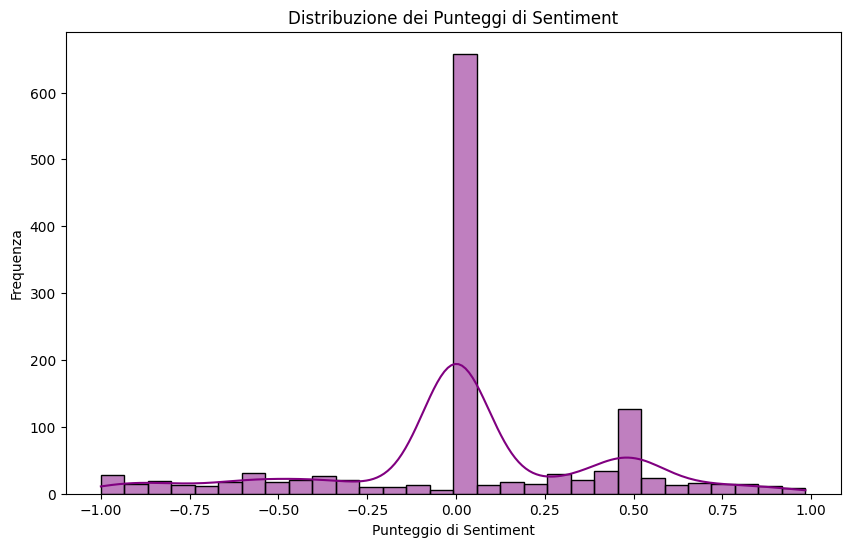

In [46]:
# Installazione della libreria per l'analisi del sentiment
!pip install nltk
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Unire i token per frase
sentences = df.groupby('Sentence_Num')['token'].apply(lambda tokens: ' '.join(tokens))

# Calcolo del punteggio di sentiment per ogni frase
sentiment_scores = sentences.apply(lambda sentence: sia.polarity_scores(sentence)['compound'])

# Aggiunta dei punteggi al DataFrame
sentiment_df = pd.DataFrame({'Sentence_Num': sentences.index, 'Sentiment_Score': sentiment_scores})

# Istogramma della distribuzione dei punteggi di sentiment
plt.figure(figsize=(10, 6))
sns.histplot(sentiment_df['Sentiment_Score'], bins=30, kde=True, color='purple')
plt.title('Distribuzione dei Punteggi di Sentiment')
plt.xlabel('Punteggio di Sentiment')
plt.ylabel('Frequenza')
plt.show()
